In [2]:
!pip install scikit-learn

  Using cached scikit_learn-1.5.2-cp311-cp311-win_amd64.whl.metadata (13 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-win_amd64.whl (11.0 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

In [3]:
# Directories for dataset
DATASET_DIR = 'C:/Users/ahosain/PetImages'

# Parameters
IMG_SIZE = (124, 124)
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 1e-4

In [4]:
# Data Transformations
data_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
# Load Dataset
dataset = datasets.ImageFolder(DATASET_DIR, transform=data_transform)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
# Load Pre-trained VGG16 
vgg_base = models.vgg16(pretrained=True)
vgg_base.features = nn.Sequential(*list(vgg_base.features.children()))

# Freezing the layers 
for param in vgg_base.features.parameters():
    param.requires_grad = False

C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Modify the classifier
vgg_base.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 1),
    nn.Sigmoid()
)


In [8]:
# Move model to GPU
vgg_base = vgg_base.cuda()

# Loss and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(vgg_base.classifier.parameters(), lr=LEARNING_RATE)


In [9]:
# Training Loop 
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

EPOCHS = 30


train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1_scores, val_aucs = [], []

for epoch in range(EPOCHS):
    vgg_base.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{EPOCHS} - Training'):
        inputs, labels = inputs.cuda(), labels.float().unsqueeze(1).cuda()
        
        optimizer.zero_grad()
        outputs = vgg_base(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        preds = torch.round(outputs)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    vgg_base.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.float().unsqueeze(1).cuda()
            outputs = vgg_base(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
            preds = torch.round(outputs)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    val_loss = running_val_loss / len(test_loader)
    val_accuracy = correct_val / total_val
    val_f1 = f1_score(y_true, y_pred)
    val_auc = roc_auc_score(y_true, y_pred)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    val_aucs.append(val_auc)
    
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

# Plotting metrics
plt.figure(figsize=(15, 10))

Epoch 1/30 - Training: 100%|███████████████████████████████████████████████████████| 1094/1094 [00:40<00:00, 27.05it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1, Train Loss: 0.1259, Train Acc: 0.9560, Val Loss: 0.0898, Val Acc: 0.9707, F1: 0.9710, AUC: 0.9708


Epoch 2/30 - Training: 100%|███████████████████████████████████████████████████████| 1094/1094 [00:39<00:00, 27.36it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 2, Train Loss: 0.0905, Train Acc: 0.9658, Val Loss: 0.0880, Val Acc: 0.9716, F1: 0.9720, AUC: 0.9717


Epoch 3/30 - Training: 100%|███████████████████████████████████████████████████████| 1094/1094 [00:40<00:00, 26.99it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 3, Train Loss: 0.0711, Train Acc: 0.9739, Val Loss: 0.1039, Val Acc: 0.9724, F1: 0.9727, AUC: 0.9726


Epoch 4/30 - Training: 100%|███████████████████████████████████████████████████████| 1094/1094 [00:42<00:00, 25.89it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 4, Train Loss: 0.0648, Train Acc: 0.9775, Val Loss: 0.1027, Val Acc: 0.9729, F1: 0.9734, AUC: 0.9730


Epoch 5/30 - Training: 100%|███████████████████████████████████████████████████████| 1094/1094 [00:43<00:00, 25.17it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 5, Train Loss: 0.0542, Train Acc: 0.9819, Val Loss: 0.1767, Val Acc: 0.9612, F1: 0.9630, AUC: 0.9606


Epoch 6/30 - Training: 100%|███████████████████████████████████████████████████████| 1094/1094 [00:43<00:00, 25.20it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 6, Train Loss: 0.0443, Train Acc: 0.9861, Val Loss: 0.1537, Val Acc: 0.9700, F1: 0.9704, AUC: 0.9701


Epoch 7/30 - Training: 100%|███████████████████████████████████████████████████████| 1094/1094 [00:53<00:00, 20.62it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 7, Train Loss: 0.0414, Train Acc: 0.9875, Val Loss: 0.1537, Val Acc: 0.9699, F1: 0.9702, AUC: 0.9701


Epoch 8/30 - Training: 100%|███████████████████████████████████████████████████████| 1094/1094 [01:06<00:00, 16.44it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 8, Train Loss: 0.0337, Train Acc: 0.9902, Val Loss: 0.1675, Val Acc: 0.9699, F1: 0.9700, AUC: 0.9702


Epoch 9/30 - Training: 100%|███████████████████████████████████████████████████████| 1094/1094 [01:04<00:00, 17.02it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 9, Train Loss: 0.0274, Train Acc: 0.9921, Val Loss: 0.2513, Val Acc: 0.9700, F1: 0.9704, AUC: 0.9701


Epoch 10/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [01:02<00:00, 17.57it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 10, Train Loss: 0.0274, Train Acc: 0.9922, Val Loss: 0.2137, Val Acc: 0.9699, F1: 0.9704, AUC: 0.9699


Epoch 11/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [01:05<00:00, 16.73it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 11, Train Loss: 0.0213, Train Acc: 0.9944, Val Loss: 0.2302, Val Acc: 0.9639, F1: 0.9651, AUC: 0.9636


Epoch 12/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [01:03<00:00, 17.24it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 12, Train Loss: 0.0200, Train Acc: 0.9950, Val Loss: 0.2807, Val Acc: 0.9680, F1: 0.9686, AUC: 0.9680


Epoch 13/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [01:08<00:00, 15.93it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 13, Train Loss: 0.0206, Train Acc: 0.9952, Val Loss: 0.2742, Val Acc: 0.9699, F1: 0.9703, AUC: 0.9700


Epoch 14/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [01:06<00:00, 16.45it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 14, Train Loss: 0.0167, Train Acc: 0.9963, Val Loss: 0.4094, Val Acc: 0.9707, F1: 0.9713, AUC: 0.9706


Epoch 15/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [01:06<00:00, 16.50it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 15, Train Loss: 0.0182, Train Acc: 0.9959, Val Loss: 0.3007, Val Acc: 0.9709, F1: 0.9714, AUC: 0.9710


Epoch 16/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [01:02<00:00, 17.39it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 16, Train Loss: 0.0140, Train Acc: 0.9967, Val Loss: 0.3793, Val Acc: 0.9700, F1: 0.9705, AUC: 0.9701


Epoch 17/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [01:05<00:00, 16.63it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 17, Train Loss: 0.0120, Train Acc: 0.9979, Val Loss: 0.3805, Val Acc: 0.9688, F1: 0.9693, AUC: 0.9689


Epoch 18/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [01:02<00:00, 17.57it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 18, Train Loss: 0.0160, Train Acc: 0.9963, Val Loss: 0.4671, Val Acc: 0.9683, F1: 0.9692, AUC: 0.9680


Epoch 19/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [01:03<00:00, 17.16it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 19, Train Loss: 0.0188, Train Acc: 0.9957, Val Loss: 0.2839, Val Acc: 0.9709, F1: 0.9714, AUC: 0.9710


Epoch 20/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [00:55<00:00, 19.64it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 20, Train Loss: 0.0135, Train Acc: 0.9980, Val Loss: 0.4153, Val Acc: 0.9685, F1: 0.9688, AUC: 0.9688


Epoch 21/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [01:04<00:00, 16.97it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 21, Train Loss: 0.0123, Train Acc: 0.9986, Val Loss: 0.4478, Val Acc: 0.9700, F1: 0.9706, AUC: 0.9700


Epoch 22/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [01:05<00:00, 16.69it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 22, Train Loss: 0.0146, Train Acc: 0.9979, Val Loss: 0.5738, Val Acc: 0.9704, F1: 0.9711, AUC: 0.9703


Epoch 23/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [01:05<00:00, 16.66it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 23, Train Loss: 0.0168, Train Acc: 0.9963, Val Loss: 0.4376, Val Acc: 0.9705, F1: 0.9709, AUC: 0.9707


Epoch 24/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [01:06<00:00, 16.41it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 24, Train Loss: 0.0119, Train Acc: 0.9977, Val Loss: 0.4132, Val Acc: 0.9704, F1: 0.9711, AUC: 0.9703


Epoch 25/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [01:02<00:00, 17.41it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 25, Train Loss: 0.0103, Train Acc: 0.9989, Val Loss: 0.5514, Val Acc: 0.9685, F1: 0.9690, AUC: 0.9687


Epoch 26/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [01:06<00:00, 16.49it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 26, Train Loss: 0.0196, Train Acc: 0.9979, Val Loss: 0.5701, Val Acc: 0.9632, F1: 0.9632, AUC: 0.9636


Epoch 27/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [01:06<00:00, 16.46it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 27, Train Loss: 0.0160, Train Acc: 0.9973, Val Loss: 0.5819, Val Acc: 0.9699, F1: 0.9706, AUC: 0.9698


Epoch 28/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [01:06<00:00, 16.43it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 28, Train Loss: 0.0117, Train Acc: 0.9983, Val Loss: 0.6634, Val Acc: 0.9685, F1: 0.9694, AUC: 0.9684


Epoch 29/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [01:04<00:00, 16.96it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 29, Train Loss: 0.0152, Train Acc: 0.9987, Val Loss: 0.7950, Val Acc: 0.9695, F1: 0.9701, AUC: 0.9695


Epoch 30/30 - Training: 100%|██████████████████████████████████████████████████████| 1094/1094 [01:02<00:00, 17.49it/s]
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 30, Train Loss: 0.0139, Train Acc: 0.9980, Val Loss: 0.6804, Val Acc: 0.9661, F1: 0.9670, AUC: 0.9660


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

In [10]:
# Evaluation
vgg_base.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.float().unsqueeze(1).cuda()
        outputs = vgg_base(inputs)
        predictions = torch.round(outputs).cpu().numpy()
        y_pred.extend(predictions)
        y_true.extend(labels.cpu().numpy())

C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [11]:
# Metrics Calculation
y_true = np.array(y_true)
y_pred = np.array(y_pred)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

In [12]:
# Print Metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')
print(classification_report(y_true, y_pred))


Accuracy: 0.9661
F1 Score: 0.9670
AUC: 0.9660
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97      3671
         1.0       0.96      0.97      0.97      3828

    accuracy                           0.97      7499
   macro avg       0.97      0.97      0.97      7499
weighted avg       0.97      0.97      0.97      7499



Text(0.5, 1.0, 'Training and Validation Accuracy')

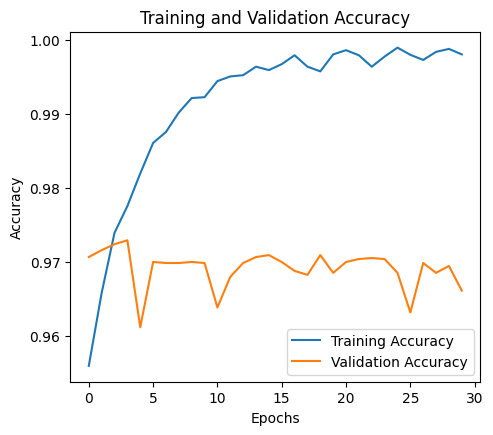

In [13]:
# Accuracy Plot
plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Validation AUC')

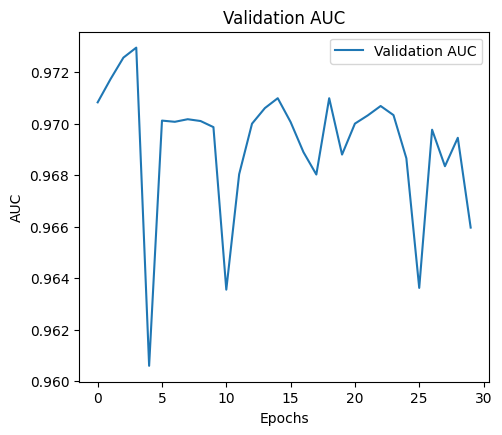

In [14]:
# AUC Plot
plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 4)
plt.plot(val_aucs, label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title('Validation AUC')

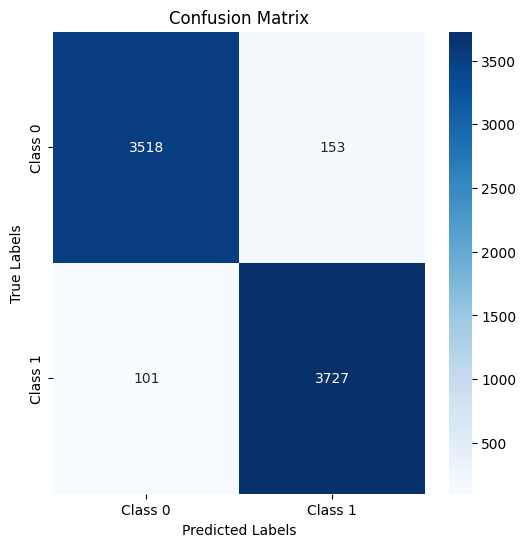

In [15]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np
# Confusion Matrix at Final Epoch
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()